# **Data Analysis**
The goal of this notebook is to showcase a basic data analysis study to make the reviewer more familiar with our data.

### **Load Data**

In [65]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import umap

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path

In [3]:
DATA_DIR = Path("./Data/Datasets")

avg_dataset = pd.read_csv(DATA_DIR / "avg_COI.csv")
random_dataset = pd.read_csv(DATA_DIR / "random_COI.csv")
combinatoric_dataset = pd.read_csv(DATA_DIR / "combinatoric_COI.csv")

### **A. Feature Distributions**

In [55]:
FEATURES = [col for col in avg_dataset.columns if col not in ['Unnamed: 0', 'Bacillus', 'Pathogene', 'Score']]

def plot_distributions(df, cols, dataset_name, hue_col="Modele", mode="feature_cross_corr"):
    if mode == "feature_cross_corr":
        sns.pairplot(df[cols], hue=hue_col)
        plt.suptitle(f"Pairplot for the {dataset_name} Dataset.", y=1.1)
        plt.show()
    elif mode == "score_corr":
        cols += ["Score"]
        sns.pairplot(df[cols], hue=hue_col, y_vars=["Score"])
        plt.suptitle(f"Feature-Score correlation plots for the {dataset_name} Dataset.", y=1.1)
        plt.show()
    else:
        raise AttributeError(f"Unknown mode. Must be either 'feature_cross_corr' or 'score_corr' but got {mode}.")

def plot_morph_distributions(df, normalize=False):
    fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Ensure adequate figure size
    
    if normalize:
        scaler = StandardScaler()
        df = pd.DataFrame(scaler.fit_transform(df[FEATURES[:-1]]), columns=FEATURES[:-1], index=df.index)
    for i, feature in enumerate(FEATURES[:-1]):
        row, col = divmod(i, 2)  # Compute grid position
        sns.histplot(df, x=feature, ax=axes[row, col], kde=True)  # Assign each plot to the right axis
        axes[row, col].set_title(f"{feature} Distribution", y=1.05, fontweight="bold", fontsize=14)

    plt.tight_layout()  # Adjust spacing to prevent overlapping
    plt.show()

def plot_violin(df, col, group_by=None):
    if group_by is not None:
        sns.violinplot(data=df, x=group_by, y=col, hue=group_by, inner='point')
        plt.title(f"Violin plot of {col} grouped by {group_by}", y=1.05, fontweight="bold", fontsize=14)
        plt.xticks(rotation=75)

    else:
        fig, axes = plt.subplots(1,2, figsize=(12, 6))
        
        sns.violinplot(data=df, x="Bacillus", y=col, hue="Bacillus", inner='point', ax=axes[0])
        axes[0].set_title(f"Grouped by Bacillus strains.", y=1.02, fontweight="bold", fontsize=10)
        axes[0].set_xticks(range(len(df["Bacillus"].unique())))  # Set tick positions
        axes[0].set_xticklabels(df["Bacillus"].unique(), rotation=75)  # Rotate labels

        sns.violinplot(data=df, x="Pathogene", y=col, hue="Pathogene", inner='point', ax=axes[1])
        axes[1].set_title(f"Grouped by Pathogen strains.", y=1.02, fontweight="bold", fontsize=10)
        axes[1].set_xticks(range(len(df["Pathogene"].unique()))) 
        axes[1].set_xticklabels(df["Pathogene"].unique(), rotation=75) 

        plt.suptitle(f"Violin plots of {col}", fontweight="bold", fontsize=14)
    plt.tight_layout()
    plt.show()

    
def plot_mixing_modele(df):
    # y = sns.barplot(df["Modele"].value_counts())
    # labels = [f"{v:.0f}" if v else '' for v in y.containers[0].datavalues]
    # y.bar_label(y.containers[0], labels=labels)
    proportions = df["Modele"].value_counts() / np.sum(df["Modele"].value_counts())

    plt.pie(proportions, labels=list(df["Modele"].value_counts().index), autopct='%.0f%%')
    plt.title('Mixing Modele Proportions.', fontweight="bold")
    plt.show()

    sns.displot(df, x="Score", hue="Modele", kind="hist", col="Modele")
    # sns.histplot(df, x="Score", hue="Modele", col="Modele", element="step",
    # stat="density", common_norm=False)
    # sns.kdeplot(df, x="Score", hue="Modele", bw_adjust=5, cut=0)
    plt.suptitle("Exclusion score distribution by Mixing Modele.", y=1.05, fontweight="bold", fontsize=16)
    plt.show()

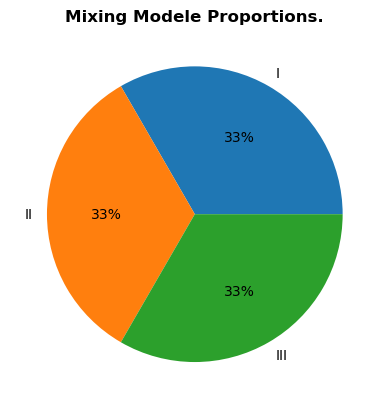

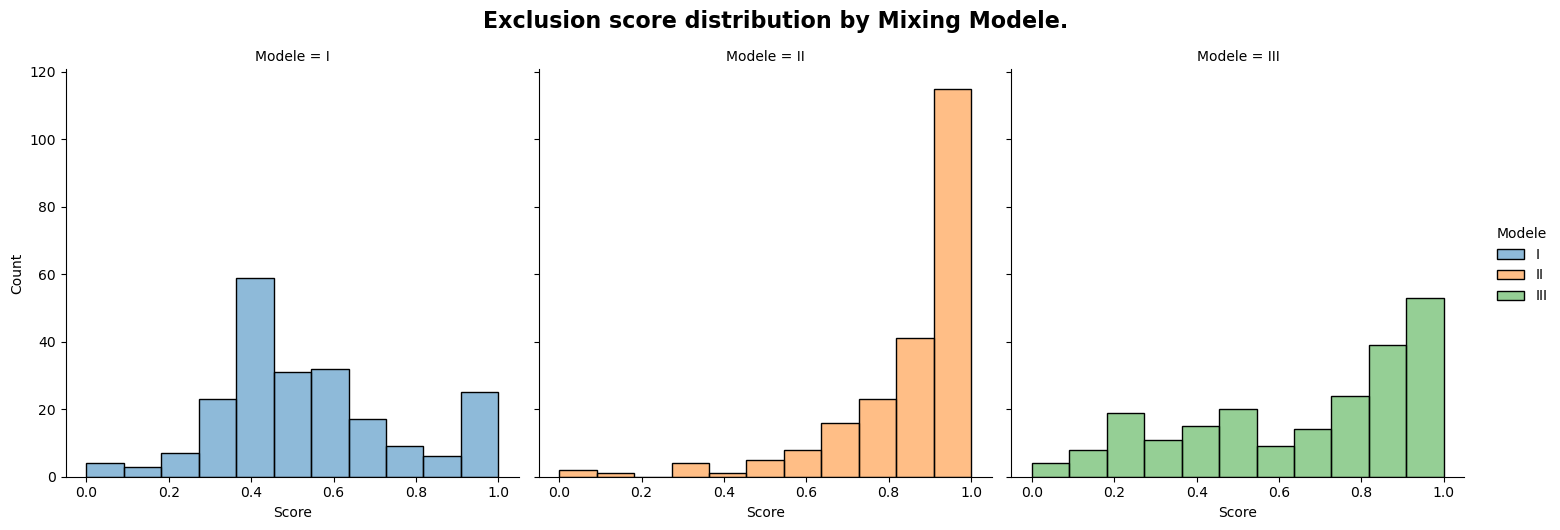

In [5]:
plot_mixing_modele(avg_dataset)

To understand the figure above, here is a reminder :
- I = Co-inoculation 24h = 24h after inoculation of 1:1 ratio of positive and undesirable strain
- II = Recrutement at t=0h = After inoculation of undesirable strain on a previously formed positive biofilm
- III = Recrutement at t=24h = 24h after II

Distributions show several insights. First of all regarding Recrutement models, right after inoculation of undesirable strains on positive biofilm (II), the exclusion score is really high since undesirable bacteria have not yet had the time to develop. However when looking at the 24h biofilms, we can see that the distribution is much less skewed, showing that in many cases, undesirable development happens which leads to decreased exclusion scores. When looking at mixing model I, scores follow more of a Gaussian distribution centered around 0.5 which suggests that as the initial ratio for this mixing model is 1:1, both strains had similar growth during last 24h.


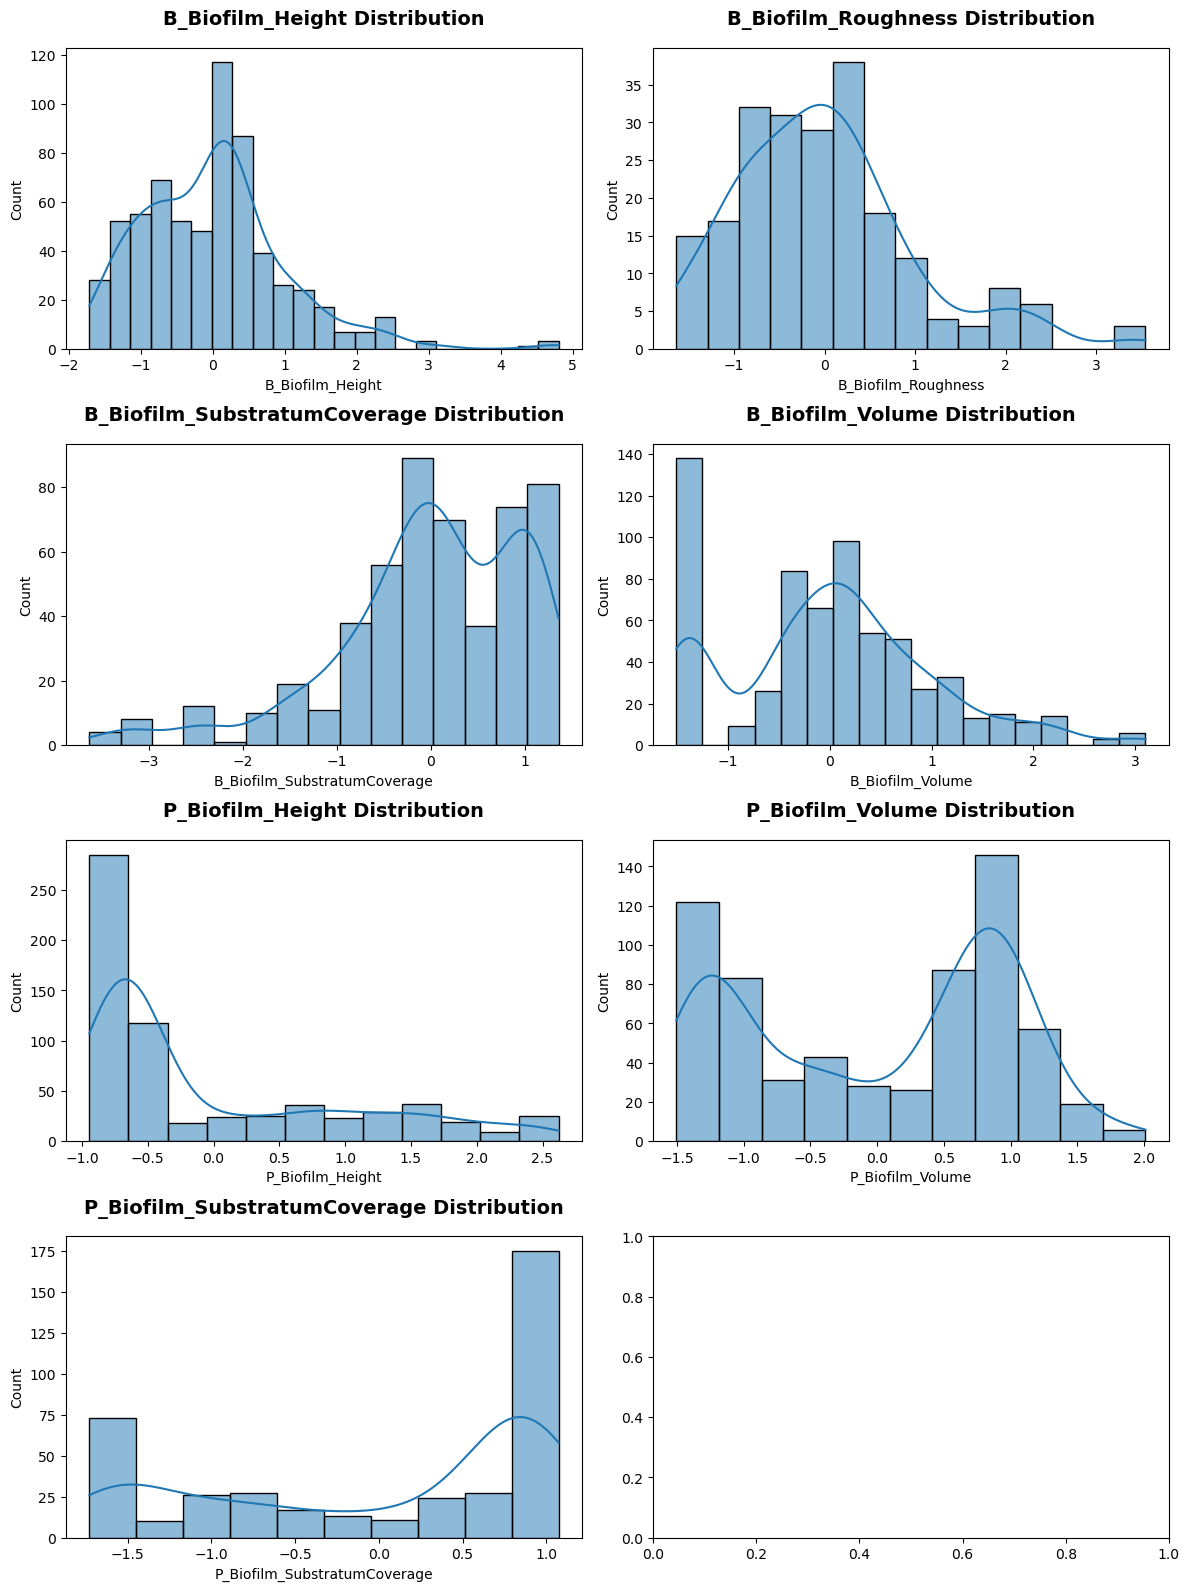

In [ ]:
plot_morph_distributions(avg_dataset, normalize=True)

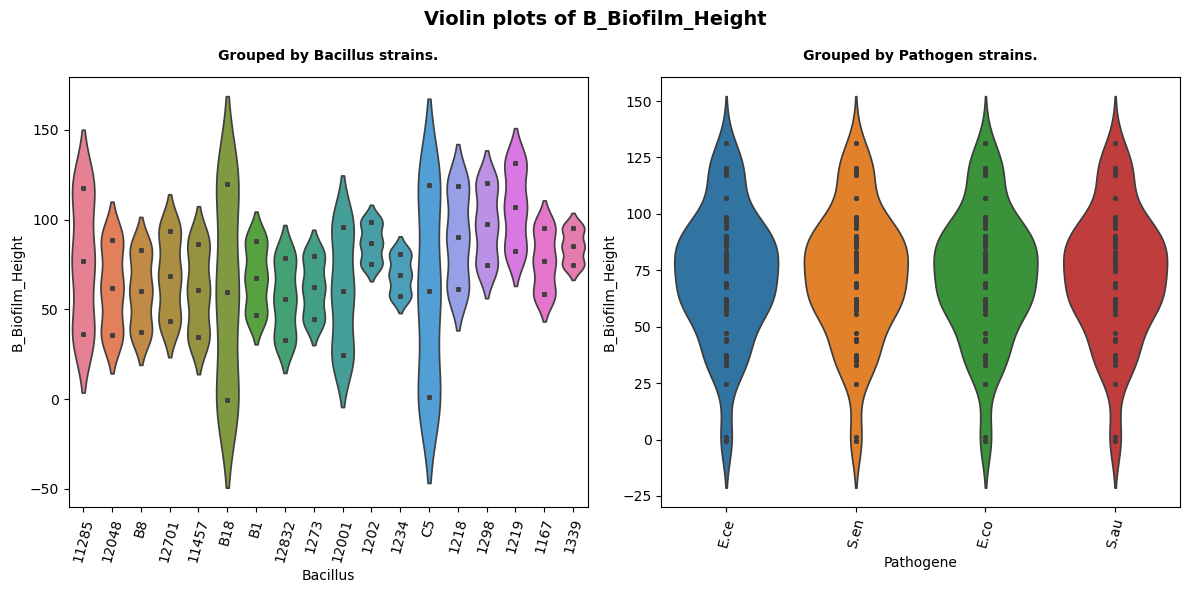

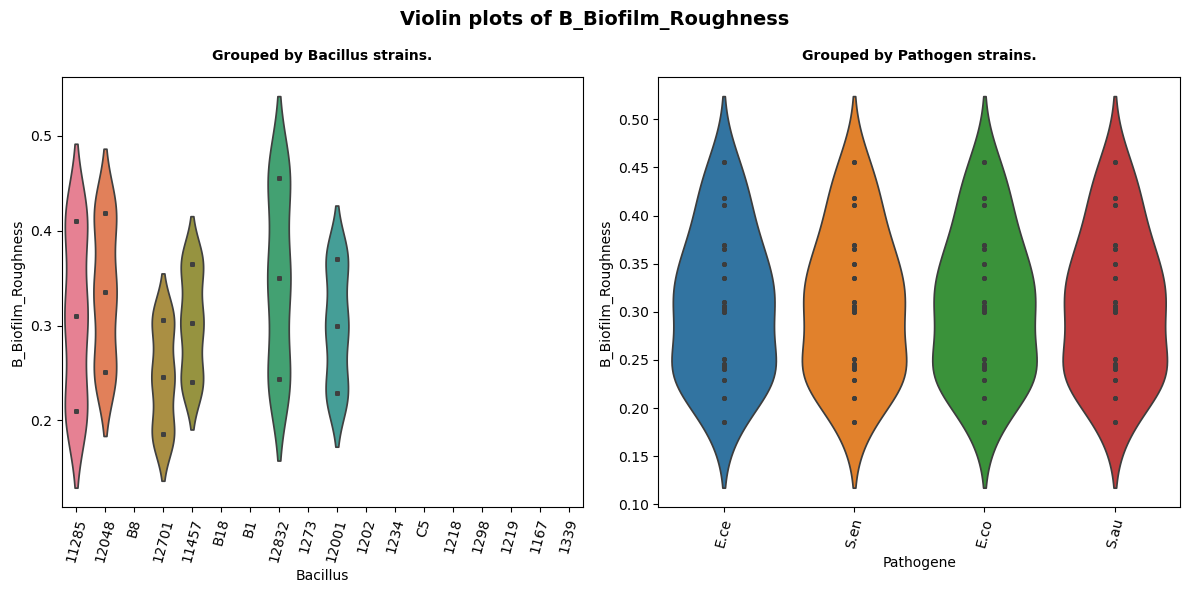

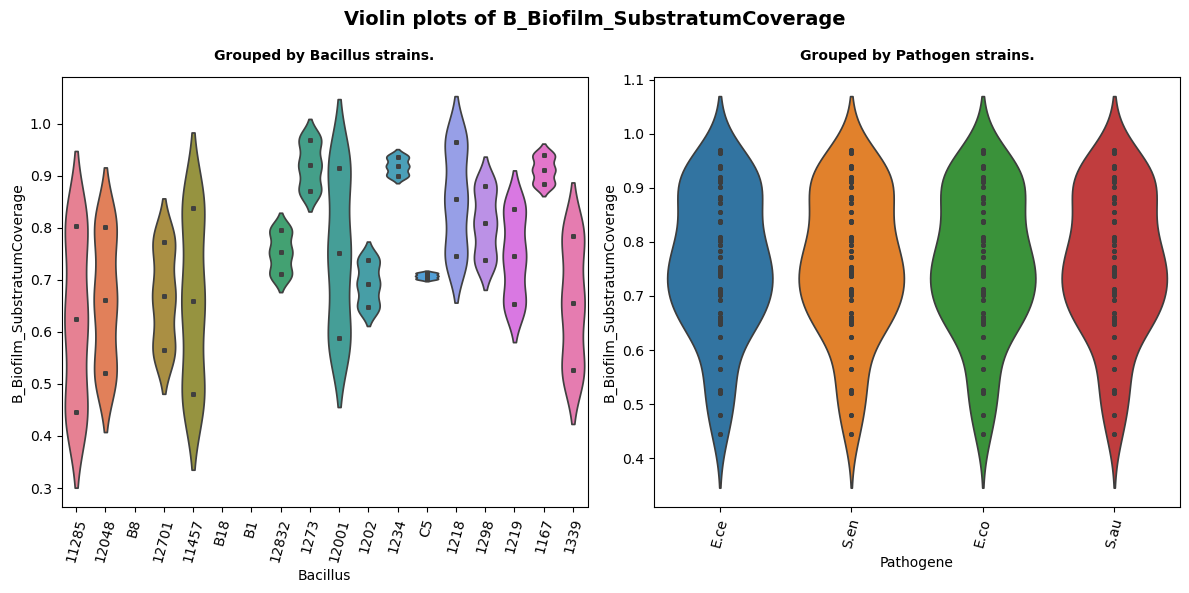

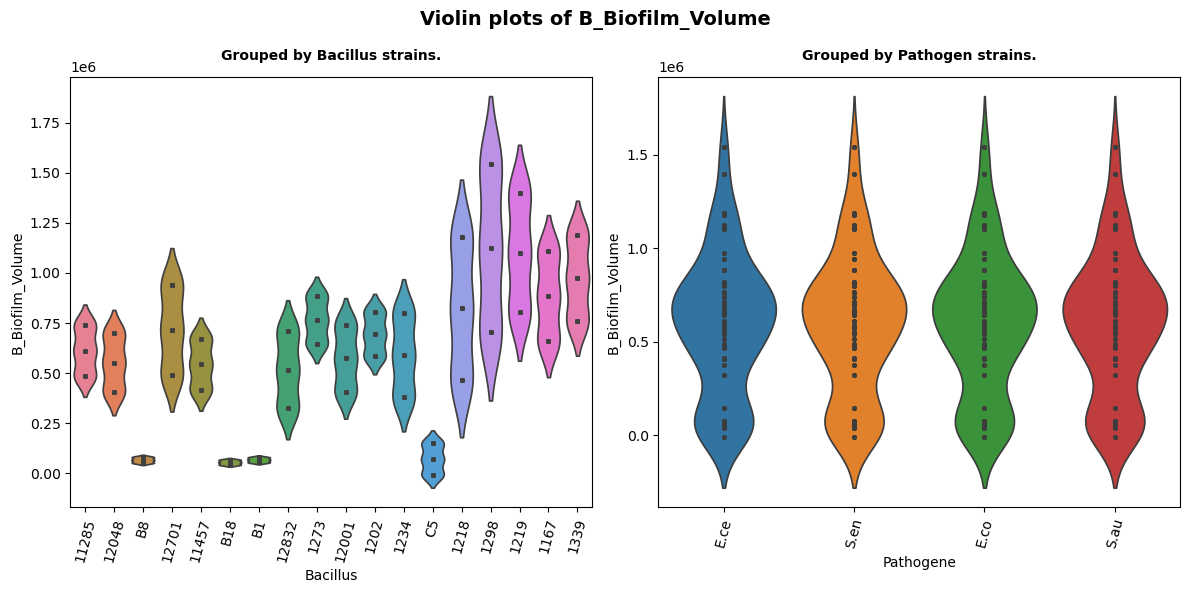

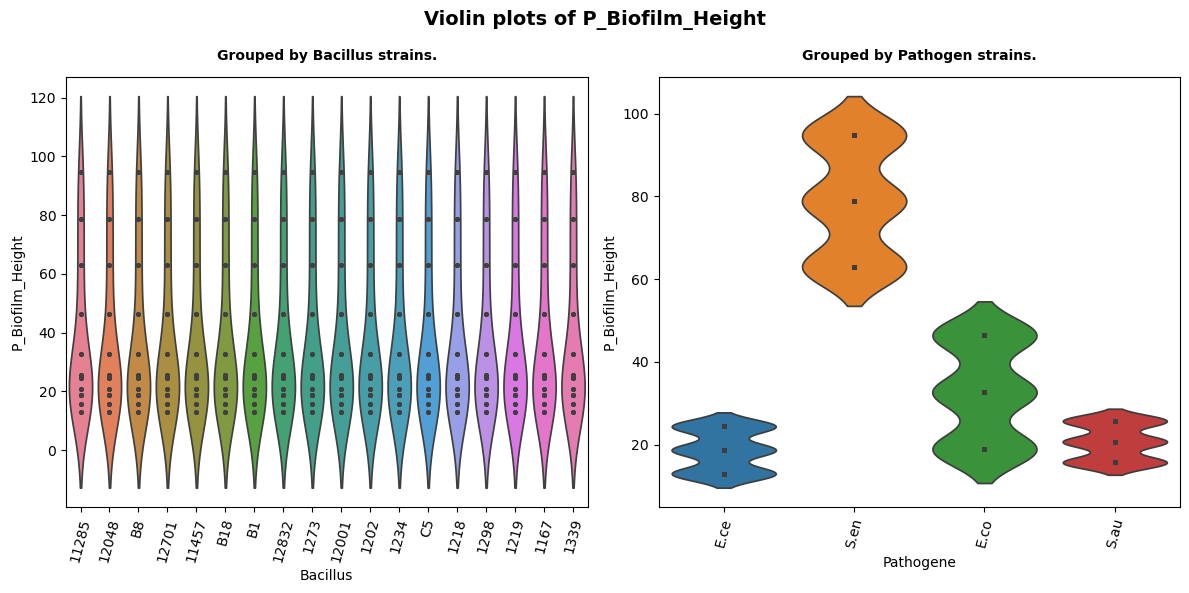

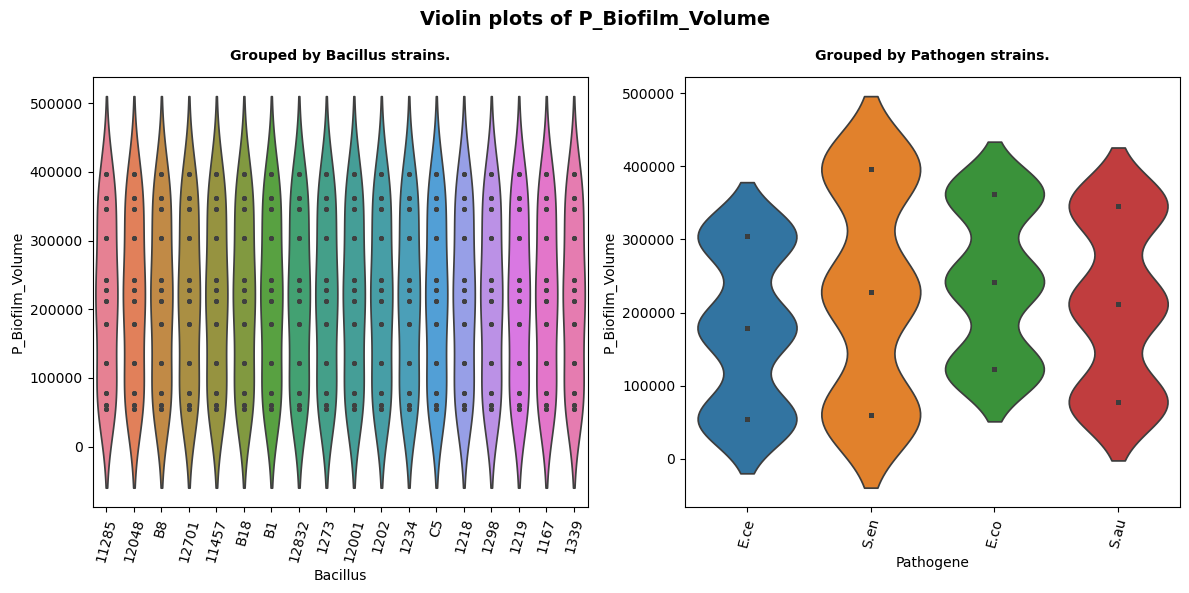

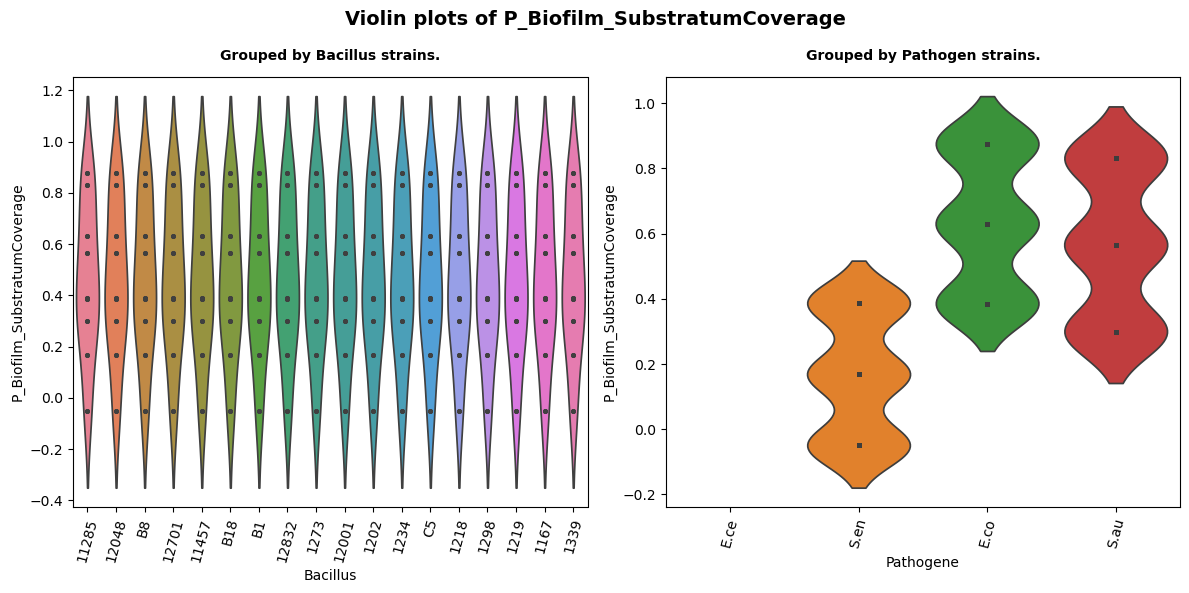

In [57]:
for feature in FEATURES[:-1]:
    plot_violin(avg_dataset, feature)

Here are a few important notes:
- B_Biofilm_Roughness is only available for {11285,12048, 12701, 11457, 12832, 12001}
- There is no data about B_Biofilm_SubstratumCoverage for {B8, B18, B1}
- There is no data about P_Biofilm_SubstratumCoverage for E.ce
- P_Biofilm_Height distribution of S.en stands out compared to the others with higher range of values.
- B_Biofilm_Volume is very low for {B8, B18, B1, C5} compared to other strains.

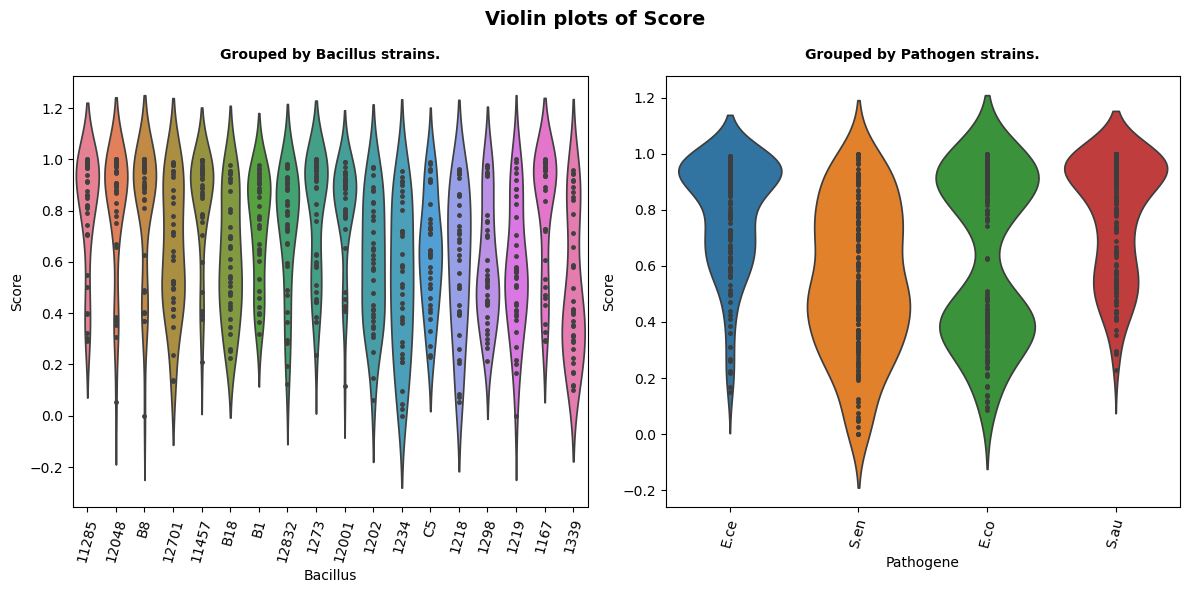

In [58]:
plot_violin(avg_dataset, "Score")

Firstly, it can be noted that some strains stand out with more skewed violins towards high exclusion scores, namely {11285, 12048, B8, 11457, 12001}. this suggests that when mixing these strains with undesirable bacteria, stronger antagonism takes place, making them a priori good candidates for positive biofilm strains.


For pathogens, we can see that overall, ranges of exclusion scores are similar across undersirable bacteria. However it can be noted that scores for S.en are more evenly distributed over this range whereas other pathegens show skewed or bimodal distributions. 

In [90]:
def compute_pca(df, columns, n_components=None):
    """
    Computes PCA on the specified columns of the dataframe.
    Plots explained variance and cumulative explained variance.
    Returns a dataframe with principal components.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        columns (list): List of column names to apply PCA on.
        n_components (int or None): Number of principal components to keep (None defaults to all).
    
    Returns:
        pd.DataFrame: Transformed dataframe with PCA components.
    """
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df[columns])
    pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])], index=df.index)

    # Plot explained variance
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance")
    plt.title("Explained Variance by Principal Component")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.grid()

    plt.tight_layout()
    plt.show()

    return pca_df

def compute_tsne(df, columns, perplexity=30, n_components=2, random_state=62):
    """
    Computes t-SNE on the specified columns of the dataframe.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        columns (list): List of column names to apply t-SNE on.
        perplexity (int): Perplexity parameter for t-SNE.
        n_components (int): Number of components for t-SNE (default: 2).
        random_state (int): Random seed for reproducibility.
    
    Returns:
        pd.DataFrame: Transformed dataframe with t-SNE components.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_components = tsne.fit_transform(df[columns])
    tsne_df = pd.DataFrame(tsne_components, columns=[f'tSNE{i+1}' for i in range(n_components)], index=df.index)

    return tsne_df

def compute_umap(df, columns, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42):
    """
    Computes UMAP on the specified columns of the dataframe.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        columns (list): List of column names to apply UMAP on.
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance for UMAP.
        n_components (int): Number of components for UMAP (default: 2).
        random_state (int): Random seed for reproducibility.
    
    Returns:
        pd.DataFrame: Transformed dataframe with UMAP components.
    """
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_components = umap_model.fit_transform(df[columns])
    umap_df = pd.DataFrame(umap_components, columns=[f'UMAP{i+1}' for i in range(n_components)], index=df.index)

    return umap_df

def visualize_embeddings(original_df, tsne_df, umap_df, color_col):
    """
    Visualizes t-SNE and UMAP embeddings with color based on a specified column.
    
    Parameters:
        original_df (pd.DataFrame): Original dataframe (for labels).
        tsne_df (pd.DataFrame): t-SNE transformed dataframe.
        umap_df (pd.DataFrame): UMAP transformed dataframe.
        color_col (str): Column name to color points by.
    
    Returns:
        None (displays plots).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # t-SNE plot
    sns.scatterplot(x=tsne_df.iloc[:, 0], y=tsne_df.iloc[:, 1], hue=original_df[color_col], palette="icefire", ax=axes[0], alpha=0.7)
    axes[0].set_title(f"t-SNE Visualization Colored by {color_col}")
    axes[0].set_xlabel("t-SNE Component 1")
    axes[0].set_ylabel("t-SNE Component 2")
    axes[0].legend(loc='best', bbox_to_anchor=(1, 1))

    # UMAP plot
    sns.scatterplot(x=umap_df.iloc[:, 0], y=umap_df.iloc[:, 1], hue=original_df[color_col], palette="icefire", ax=axes[1], alpha=0.7)
    axes[1].set_title(f"UMAP Visualization Colored by {color_col}")
    axes[1].set_xlabel("UMAP Component 1")
    axes[1].set_ylabel("UMAP Component 2")
    axes[1].legend(loc='best', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df, column=None, cmap="coolwarm", annot=True):
    """
    Plots a correlation heatmap for a given dataframe. 
    If a specific column is provided, it plots correlations between that column and all others.
    If no column is specified, it shows the full pairwise correlation matrix.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        column (str or None): The column to compute correlation against. If None, full correlation matrix is shown.
        cmap (str): Colormap for the heatmap (default: "coolwarm").
        annot (bool): Whether to annotate heatmap cells with correlation values (default: True).
    
    Returns:
        None (displays the heatmap).
    """
    plt.figure(figsize=(10, 8))

    if column:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in the dataframe.")
        corr_matrix = df.corr()[[column]].sort_values(by=column, ascending=False)  # Sort by correlation value
    else:
        corr_matrix = df.corr()

    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, center=0, linewidths=0.5, fmt=".2f")

    title = f"Correlation Heatmap of {column}" if column else "Pairwise Correlation Heatmap"
    plt.title(title, fontsize=14, fontweight="bold")

    plt.show()


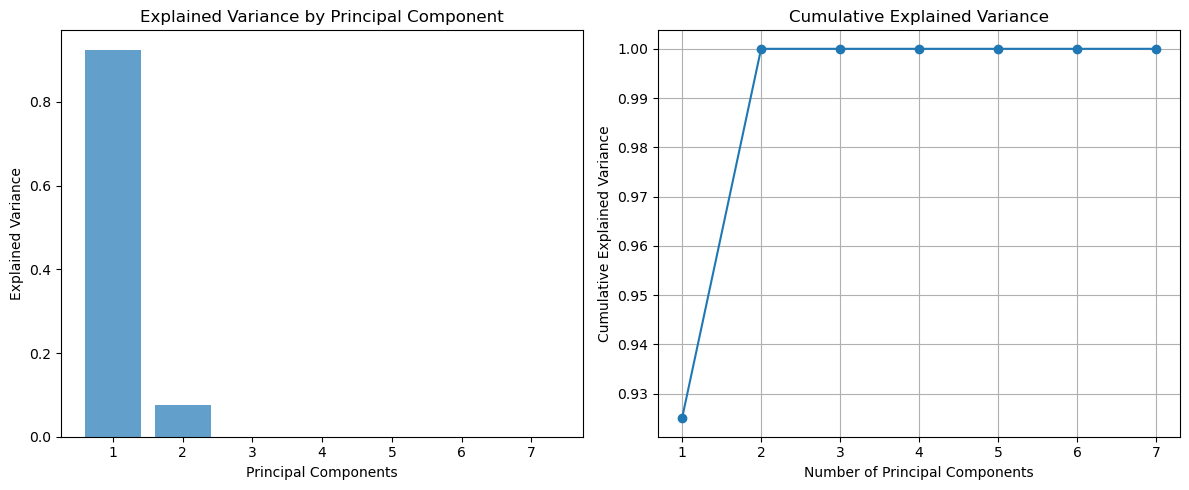

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-p

In [67]:
# Impute NAs
knn = KNNImputer()
noNA_avg_dataset = pd.DataFrame(knn.fit_transform(avg_dataset[FEATURES[:-1]]), columns=FEATURES[:-1], index=avg_dataset.index)
pca_df = compute_pca(noNA_avg_dataset, FEATURES[:-1])
tsne_df = compute_tsne(noNA_avg_dataset, FEATURES[:-1])
umap_df = compute_umap(noNA_avg_dataset, FEATURES[:-1])

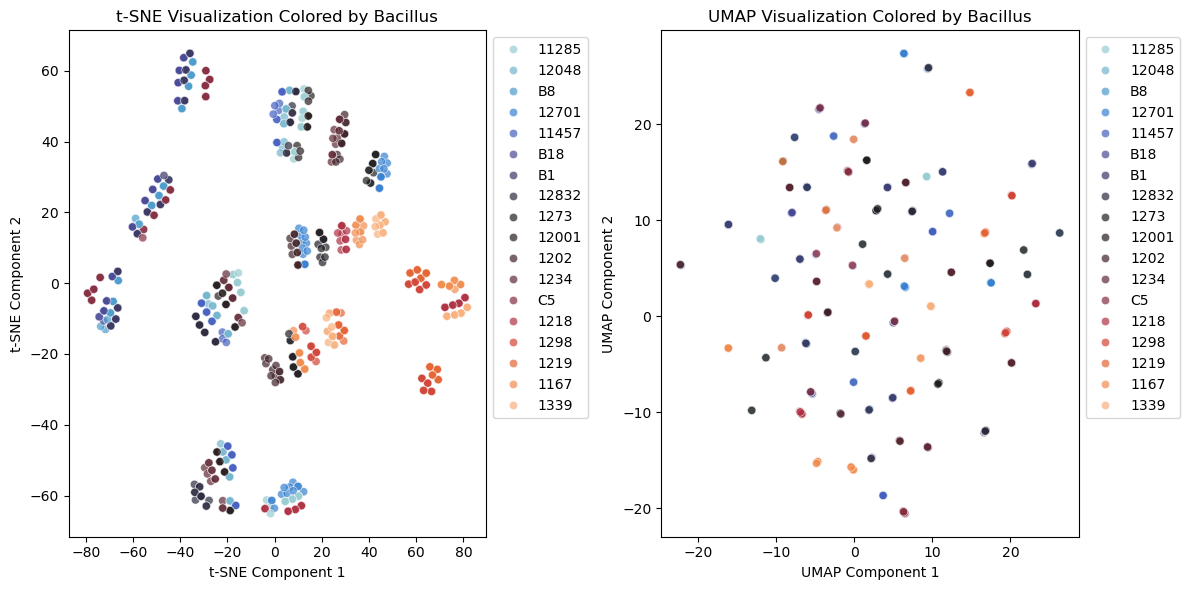

In [79]:
visualize_embeddings(avg_dataset, tsne_df, umap_df, "Bacillus")

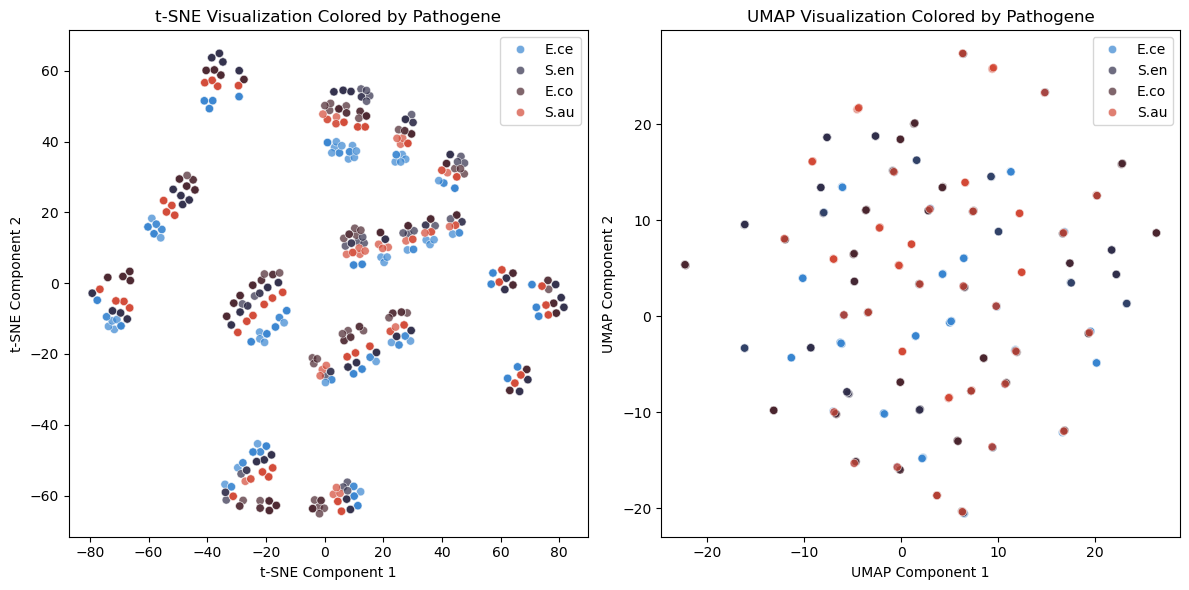

In [80]:
visualize_embeddings(avg_dataset, tsne_df, umap_df, "Pathogene")

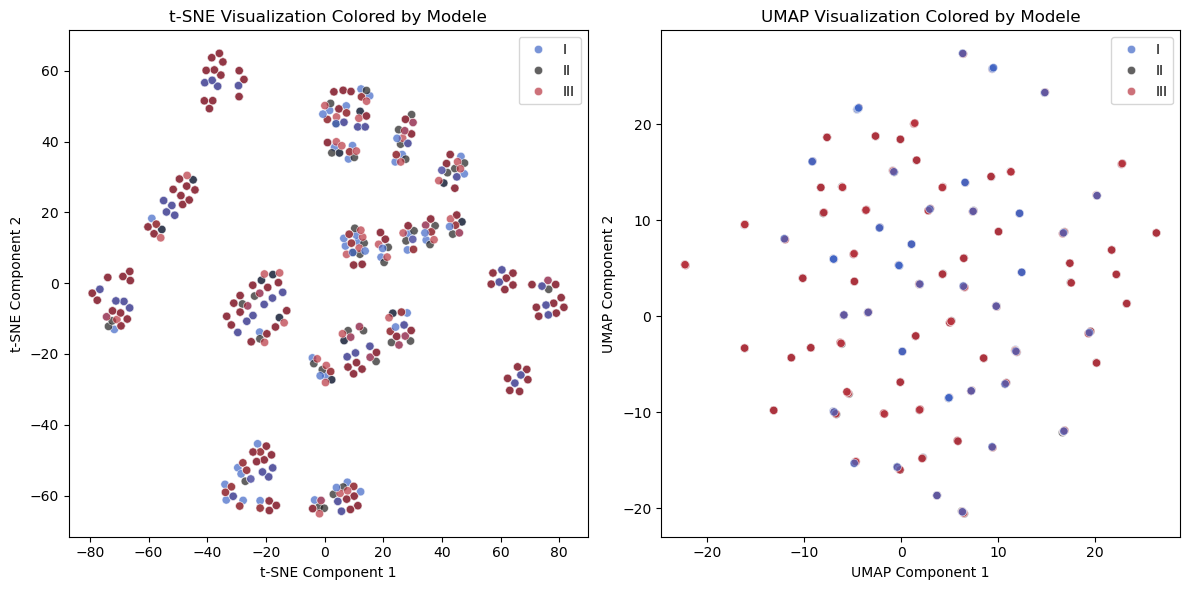

In [81]:
visualize_embeddings(avg_dataset, tsne_df, umap_df, "Modele")

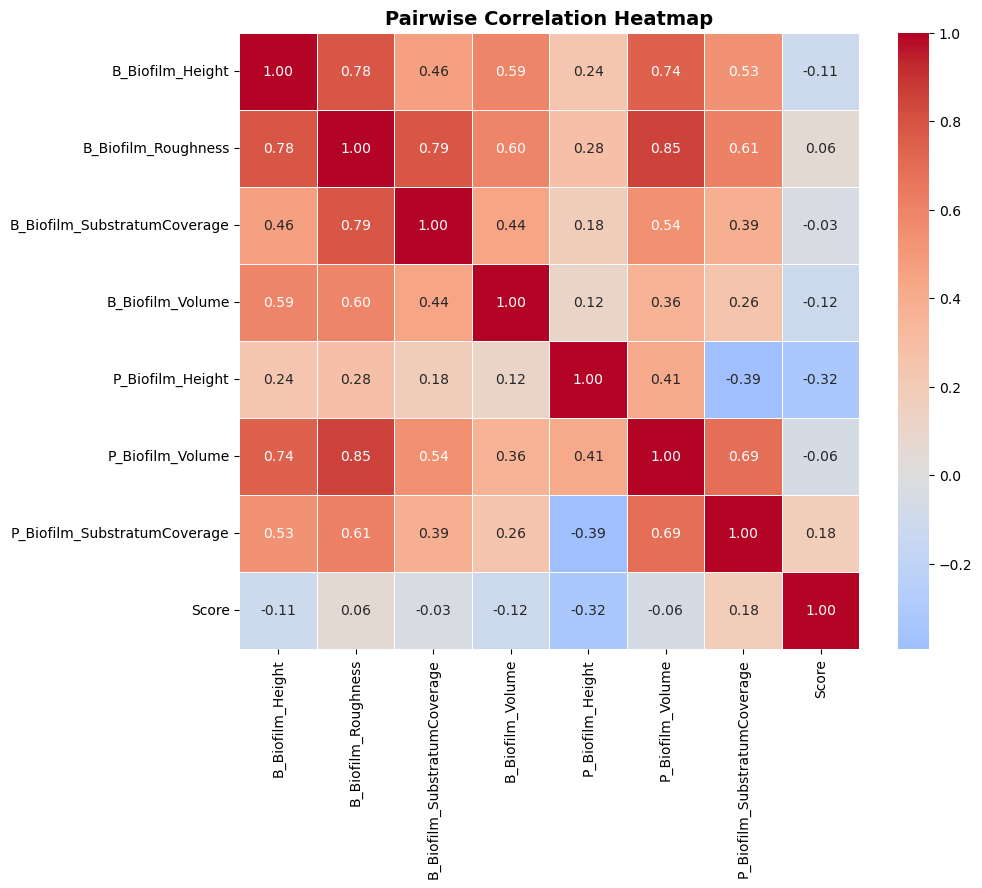

In [92]:
plot_correlation_heatmap(avg_dataset[FEATURES[:-1] + ["Score"]], None)